### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt

import sys

#add path
sys.path.insert(0, '../../synthPy_restructured')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
#import propagator_backup_non_jax as p
import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

<module 'utils' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/examples/notebooks/../../synthPy_restructured/utils.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [3]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 512

x = np.linspace(-extent_x, extent_x, n_cells)
y = np.linspace(-extent_y, extent_y, n_cells)
z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

#domain = d.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

Load some domain distribution

In [4]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
domain.test_exponential_cos()
#domain.test_slab(0.000001, 1e24)

Solve gradients, initialise beam, and solve

In [5]:
wl = 1064e-9 #define laser wavelength

# initialise beam
Np = 512    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)

tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False)

# solve ray trace
tracer.calc_dndr()
final_rays = tracer.solve(parallelise = True, jitted = True)
#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")


Available devices: [CpuDevice(id=0)]

jax compilation of solver took: 0.0019922256469726562
Running device: cpu, with: 16 cores.


/home/administrator/Programs/anaconda3/envs/testing/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: A large amount of constants were captured during lowering (1.61GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. The subsequent report may be disabled by setting JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=0.

Largest -1 allocation(s):
  Constant <class 'jaxlib._jax.ArrayImpl'>, float32[512,512,512], 536.87MB captured at:
 Exception raised while generating report: Failed to find index 12 in jaxpr.invars while building report
  warnings.warn(message + f" Exception raised while generating report: {exc}")


KeyboardInterrupt: 

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


rf size expected: (100000, 100000)
rf after clearing nan's: (85965, 85965)


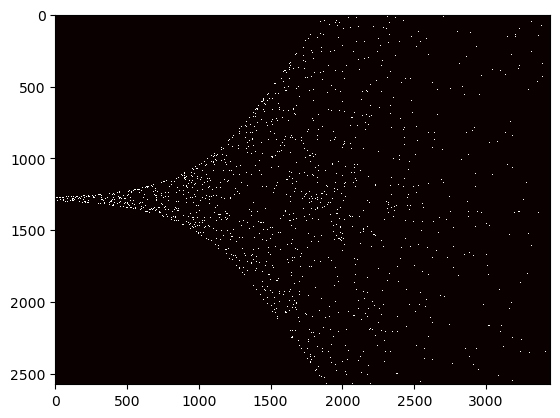

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(tracer.Beam)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (100000, 100000)
rf after clearing nan's: (85965, 85965)


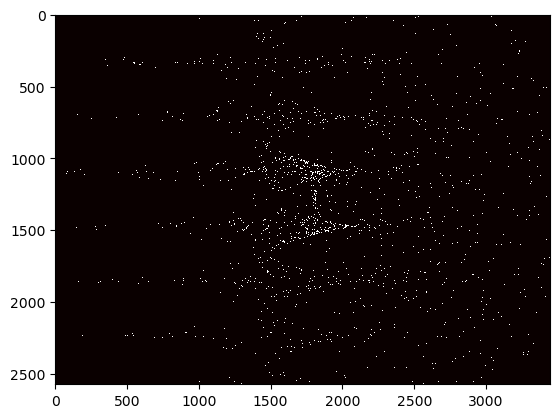

In [ ]:
shadowgrapher = diag.Shadowgraphy(tracer.Beam)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (100000, 100000)
rf after clearing nan's: (63835, 63835)


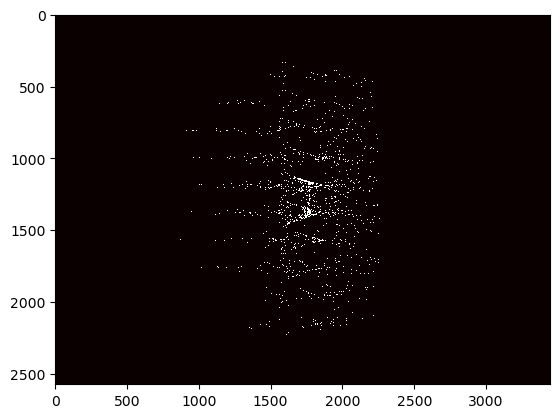

In [ ]:
schlierener = diag.Schlieren(tracer.Beam)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [ ]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = True)

tracer.calc_dndr()

tracer.Beam.rf, tracer.Beam.Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

interferometrer = diag.Interferometry(tracer.Beam)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(tracer.Beam)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H



x-y size expected: (100000, 100000)
Final rays: [[ 6.65397454e-04 -2.21510549e-03  1.47749097e-03 ... -2.73038778e-04
  -4.28212450e-03  2.76763238e-04]
 [-2.20713203e-04  2.18032596e-04 -3.30969217e-03 ...  7.62827334e-04
   9.15096589e-04 -3.30811261e-03]
 [ 1.82842712e-02  1.82842712e-02  1.82842713e-02 ...  1.82842712e-02
   1.82842712e-02  1.82842712e-02]
 ...
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [-1.36364364e+02 -7.39544232e+00 -3.56880846e+02 ... -1.24046851e+01
  -8.08450574e-01 -2.98044620e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
x-y after clearing nan's: (100000, 100000)


AttributeError: 'numpy.ndarray' object has no attribute 'at'

In [ ]:
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')

AttributeError: 'Interferometry' object has no attribute 'H'